<h1>Kangaroo Detection</h1>

Author: Vaasudevan Srinivasan <br>
Created on: July 22, 2021

[Mask RCNN Github](https://github.com/matterport/Mask_RCNN)

[Machine Learning Mastery Blog](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/)

[Kangaroo Dataset](https://github.com/experiencor/kangaroo)

In [ ]:
%%capture

# Download the code repository and dataset repository
!git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/experiencor/kangaroo.git

# Install the packages
!pip install split-folders

# Download the weights file
!wget -nc https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
%%capture

# https://stackoverflow.com/a/67966043
# Before running this cell modify the import as below
# import keras.engine.topology as KE instead of import keras.engine as KE

# Install mrnn python package
%cd Mask_RCNN
!python setup.py install
%cd ..

In [ ]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [ ]:
from mrcnn.visualize import display_instances
from mrcnn.utils import Dataset, extract_bboxes
from mrcnn.config import Config
from xml.etree import ElementTree
from glob import glob
import tensorflow as tf
import numpy as np
import splitfolders
import os

tf.__version__

'2.5.0'

# Data Preparation

In [ ]:
# Split the folders into train (80%) and test (20%)
splitfolders.ratio('kangaroo', output='kangaroo', seed=1337, ratio=(.8, .2))

Copying files: 333 files [00:00, 5676.36 files/s]


In [ ]:
class KangarooDataset(Dataset):

    def load_dataset(self, dataset_dir):

        # Add the dataset class
        self.add_class('dataset', 1, 'kangaroo')

        # Get the list of images and annotations
        images = sorted(glob(f'{dataset_dir}/images/*'))
        annots = sorted(glob(f'{dataset_dir}/annots/*'))
        for img, annot in zip(images, annots):
            image_id = os.path.splitext(os.path.basename(img))[0]
            self.add_image('dataset', image_id=image_id,
                           path=img, annotation=annot)
            
    def extract_boxes(self, xml_file):

        # Read the XML file
        root = ElementTree.parse(xml_file)

        # Width and Height
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
    
        # For all Bounding Boxes
        categories = ['xmin', 'ymin', 'xmax', 'ymax']
        boxes = []
        for box in root.findall('.//bndbox'):
            boxes.append([int(box.find(cat).text) for cat in categories])

        return boxes, width, height

    def load_mask(self, image_id):

        # Get the bounding box information
        info = self.image_info[image_id]
        boxes, w, h = self.extract_boxes(info['annotation'])

        # Create the Mask
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []
        for ix, box in enumerate(boxes):
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, ix] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, np.asarray(class_ids, dtype='int32')

In [ ]:
train_set = KangarooDataset()
train_set.load_dataset('kangaroo/train')
train_set.prepare()

test_set = KangarooDataset()
test_set.load_dataset('kangaroo/val')
test_set.prepare()

print(len(train_set.image_ids), len(test_set.image_ids))

131 33


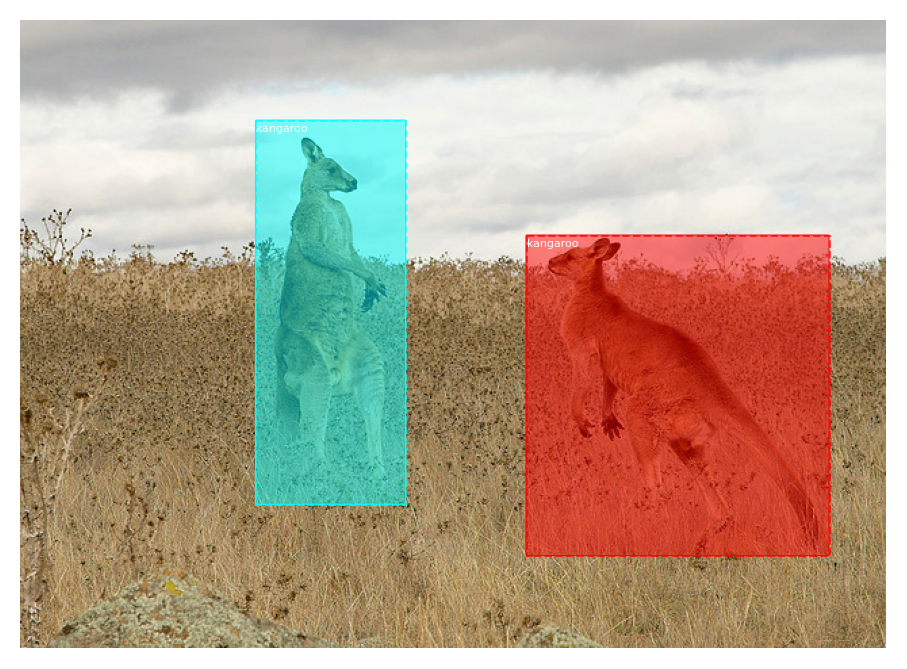

In [ ]:
# Visualization
image_id = 1
image = test_set.load_image(image_id)
mask, class_ids = test_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, test_set.class_names)

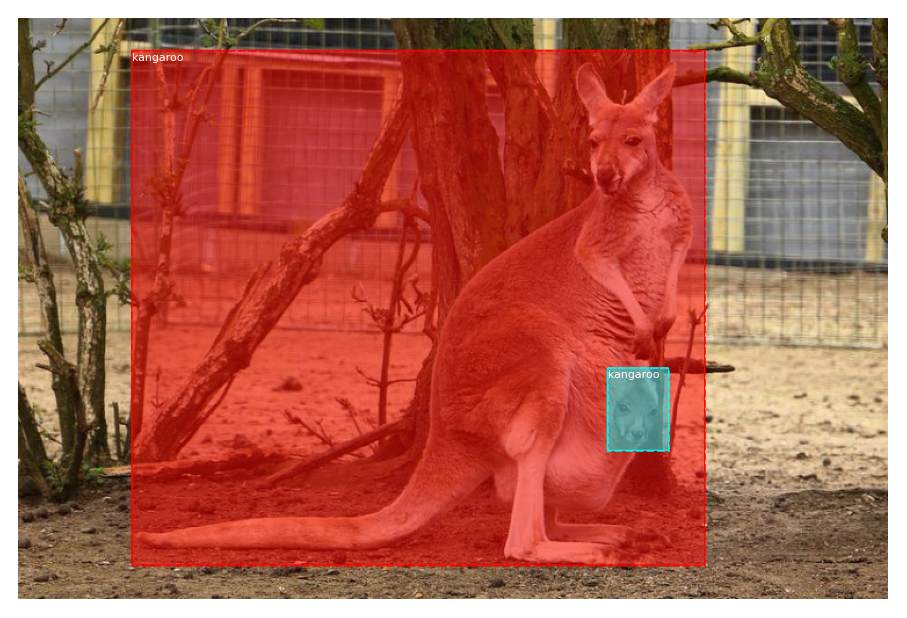

In [ ]:
# Visualization
image_id = 2
image = test_set.load_image(image_id)
mask, class_ids = test_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, test_set.class_names)